In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

In [2]:
output_dir = '/Users/kumiori3/Documents/WIP/Nature/paper_IJTCAM/technology/fig'

In [849]:
class SymbolicDiscreteDamage:
    def __init__(self, matpar,  
                 name = "discrete generalised damage",
                 slug = "pw-linear"):
        self.matpar = matpar
        self.state = self.get_state(self.matpar['N'])
        self.str = name
        self.slug = slug
        self.symbols = {str(key): sp.symbols(key) for key in ["N", "γ", "w1", "E0", "L", "t"]}

    def get_state(self, N):
        u = sp.symbols([f"u{i}" for i in range(0, N)])
        e = sp.symbols([f"e{i}" for i in range(1, N+1)])
        α = sp.symbols([f"α{i}" for i in range(1, N+1)])

        state = {"u": u, "α": α, "e": e}
        return state

    def _s(self, α):
        s = sp.Function('s')
        return s(α)

    def _a(self, α):
        a = sp.Function('a')
        return a(α)
    
    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def energy(self):
        """Total energy"""
        return self._elastic() + self._damage() - self.work()

    def work(self):
        return 0

    def _elastic(self):
        state = self.state
        e = state["e"]
        α = state["α"]

        E0 = self.symbols["E0"]
        N = self.symbols["N"]
    
        return 1/N * sum([1./2. * E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _damage(self):
        state = self.state
        _α = state["α"]
        _w1 = self.symbols["w1"]
        N = self.symbols["N"]

        return 1/N * sum([_w1 * self._w(_α[i]) for i in range(len(_α))])

    # Explicit expressions

    def a(self, α):
        γ = self.symbols['γ']
        return (1 - self._w(α)) / ((γ-1) * self._w(α) + 1)

    def w(self, α):
        return α

    def s(self, α):
        return 1. / self.a(α)

    def boundary_condition(self):
        t, L, N = sp.symbols("t L N")

        return t*N/L       

    def __str__(self):
     return self.str
 
 
def PwLinearQuadratic(SymbolicDiscreteDamage):
    def __init__(self, matpar,  
                 name = "discrete generalised damage",
                 slug = "pw-linear-quadratic"):
        super(PwLinearQuadratic).__init__(matpar, name, slug)




In [782]:
import sympy as sp
import numpy as np

class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __str__(self):
        return self.model.slug

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        # Define symbols
        self._β = sp.symbols("β")
        self._e = sp.symbols("e")

        # Define model-specific derivatives
        self._s = model.s(self._β)
        self._sp = sp.diff(self._s, self._β)
        self._spp = sp.diff(self._s, self._β, 2)

        self._a = model.a(self._β)
        self._ap = sp.diff(self._a, self._β)
        self._app = sp.diff(self._a, self._β, 2)

        self._w = model.w(self._β)
        self._wp = sp.diff(self._w, self._β)
        self._wpp = sp.diff(self._w, self._β, 2)

    def _state_homog_substitutions(self):
        """Substitutions for the homogeneous state"""
        state = self.state
        αt = sp.symbols("α_t")
        et = sp.symbols("e_t")

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh

    def _equilibrium_e(self):
        state = self.state
        t, L, N = sp.symbols("t L N")
        _S = sum([self.model._s(αi) for αi in state["α"]])

        datum = self.model.boundary_condition()

        _e = [(datum * self.model._s(αi) / _S).simplify() for αi in state["α"]]

        return _e

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        t, L, N = sp.symbols("t L N")

        _e0 = t / L

        _homogeneous_damage, _homogeneous_strain = self._state_homog_substitutions()

        _crit = sp.diff(
            model.energy().subs(_homogeneous_damage).subs(_homogeneous_strain),
            sp.symbols("α_t"),
        ).subs({sp.symbols("e_t"): _e0, sp.symbols("α_t"): 0})

        return _crit.simplify()

    def critical_load(self, matpar={}):
        """Critical load"""
        t = sp.symbols("t")

        criterion = (
            self.criterion()
            .replace(sp.Function("a"), self.model.a)
            .replace(sp.Function("w"), self.model.w)
            .simplify()
        )
        tc = sp.solve(criterion, t)
        _tc = [t for t in tc if sp.posify(t)[0].is_positive]
        
        if matpar:
            return [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]

        return _tc

    def homogeneous_energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_homog_α, _ = self._state_homog_substitutions()
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy()
            .subs(equilibrium_subs)
            .subs(subs_homog_α)
            .subs(subs_s_inverse)
            .subs({N: self.matpar["N"]})
            .simplify()
        )

    def energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def _elastic_energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model._elastic()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def _damage_energy_fc_alpha(self):
        return self.model._damage().simplify()

    def criterion_α(self, matpar={}):
        """Evolution law for damage"""
        αt = sp.symbols("α_t")

        subs_homog_α, _ = self._state_homog_substitutions()

        energy = (
            self.homogeneous_energy_fc_alpha()
            .replace(sp.Function("a"), self.model.a)
            .replace(sp.Function("w"), self.model.w)
            .doit()
        )

        if matpar:
            energy = energy.subs(matpar)

        return sp.diff(energy, αt)

    def homogeneous_α(self, matpar={}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols("α_t")

        if matpar:
            return [
                sol.subs(matpar)
                for sol in map(sp.simplify, sp.solve(self.criterion_α(matpar), αt))
            ]
        else:
            return list(map(sp.simplify, sp.solve(self.criterion_α(), αt)))
            
    def homogeneous_damage(self, matpar={}):
        evos = [evo.subs(matpar) for evo in self.homogeneous_α(matpar)]
        idx = self.positive_solution_wrt_t(evos, matpar)
        evo_x = evos[idx].subs(matpar)
        
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = self.critical_load(matpar)[0]
        t = sp.symbols("t")

        alpha = sp.Piecewise((_alpha, t >= tc), (0, t < tc))

        return alpha

    def positive_solution_wrt_t(self, f, _matpar={}):
        idx = np.where(
            np.array([sp.diff(_f.subs(_matpar), sp.symbols("t")) for _f in f]) > 0
        )[0]
        return idx[0]

    def _elastic_energy_m_bifurcations(self):
        n = len(self.state["α"])
        m = sp.symbols("m")
        N = sp.symbols("N")
        _s = sp.Function("s")
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]

        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")
        return 1.0 / 2.0 * E0 * (N * t / L) ** 2 * 1 / ((N - m) * _s(ax) + m * _s(at))

    def energy_m_bifurcations(self):
        # n = len(self.state["α"])
        m = sp.symbols("m")
        N = self.model.symbols["N"]
        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")

        return self._elastic_energy_m_bifurcations() + self.model.symbols["w1"] * (
            m * self.model.w(at) + (N - m) * self.model.w(ax)
        )

    def elastic_energy_xi_bifurcations(self):
        n = len(self.state["α"])
        N = sp.symbols('N')
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]
        return 1./2. * E0 * (t / L)**2 * 1 / (_s(ax) + (xi)*(_s(at)-_s(ax)))
        
    def energy_xi_bifurcations(self):
        n = len(self.state["α"])
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        N = sp.symbols('N')
        xi = sp.symbols('xi')
        
        return self.elastic_energy_xi_bifurcations() +   \
            self.model.symbols["w1"] * (xi * self.model.w(at) + (1-xi) * self.model.w(ax))

    def diff_energy_xi_bifurcations(self):
        n = len(self.state["α"])
        n = N
        # _s = model.model.s
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]
        
        return - 1./2. * E0 * (t / L)**2 * xi * sp.diff(_s(at), at) / ((_s(ax) + (xi)*(_s(at)-_s(ax))))**2 + \
            self.model.symbols["w1"] * (xi * sp.diff(self.model.w(at), at) ) 


In [783]:
N = sp.symbols("N")
t = sp.symbols('t')
γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

_N = 2
_normalise = {E0: 1, w1: 1, L: 1}

_α = sp.symbols("α")
β = sp.symbols('β')


_matpar = {"N": _N, "γ": 4, "E0": 2, "w1": 2, "L": 1}
# matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(_matpar)
model = ModelAnalysis(atls)

model.criterion()


1.0*E0*t**2*Subs(Derivative(a(α_t), α_t), α_t, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(α_t), α_t), α_t, 0)/N

In [750]:
atls.symbols

{'N': N, 'γ': γ, 'w1': w1, 'E0': E0, 'L': L, 't': t}

In [751]:
model.critical_load()

[1.4142135623731*L*sqrt(w1/(E0*γ))]

In [752]:
model.critical_load(matpar=_matpar)

[0.707106781186548]

Text(0.5, 1.0, 'Critical load vs. γ - Model: pw-linear')

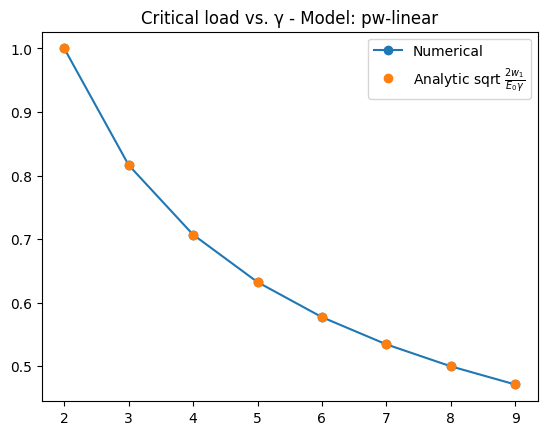

In [753]:
critical_loads = []
parameters = _matpar.copy()

for gamma in range(2, 10):
    parameters.update({γ: gamma})
    # print(model.critical_load(matpar=parameters)
    tc = model.critical_load(matpar=parameters)[0]
    _w1 = parameters["w1"]
    _E0 = parameters["E0"]
    critical_loads.append({"γ": gamma, "tc": tc, "tc_analytical": sp.sqrt(2.*_w1/(gamma*_E0))})


fig, ax = plt.subplots()
ax.plot([d["γ"] for d in critical_loads], [d["tc"] for d in critical_loads], label="Numerical", marker='o')
ax.plot([d["γ"] for d in critical_loads], [d["tc_analytical"] for d in critical_loads], label="Analytic sqrt $\\frac{2w_1}{E_0 \\gamma}$", marker='o', ls='')
plt.legend()
ax.set_title(f'Critical load vs. γ - Model: {atls.slug}')

In [754]:
model.energy_fc_alpha()

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

In [755]:
model.homogeneous_energy_fc_alpha()

0.5*E0*t**2*a(α_t)/L**2 + w1*w(α_t)

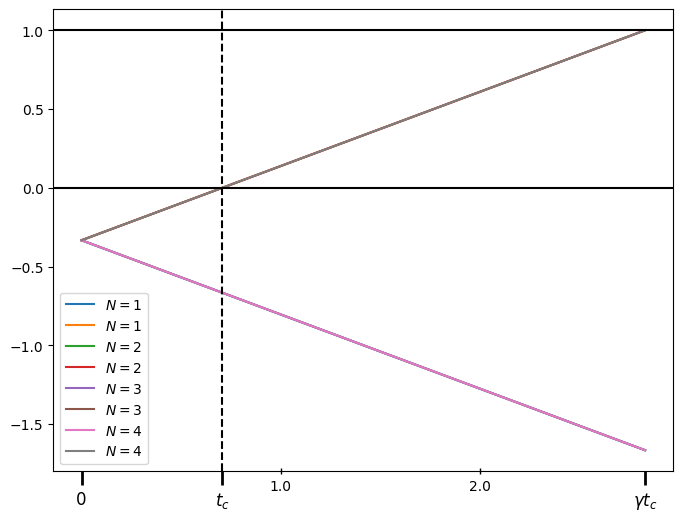

In [756]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
parameters = _matpar.copy()

for _N in range(1, 5):
    parameters.update({N: _N})
    tc = model.critical_load(matpar=parameters)[0]
    _loads = np.linspace(0., float(parameters['γ'] * tc), 30)
    atls = SymbolicDiscreteDamage(parameters, _N)
    model = ModelAnalysis(atls)
    evos = [evo.subs(parameters) for evo in model.homogeneous_α(_matpar)]
    idx = model.positive_solution_wrt_t(evos, parameters)
    evo_x = evos[idx].subs(parameters)

    for alphas in evos:
        _f = sp.lambdify(t, alphas.subs(parameters), 'numpy')
        plt.plot(_loads, _f(_loads), label=f"$N={_N}$")
    

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

ax.axvline(float(tc), c='k', ls='--')
ax.axhline(0, c='k')
ax.axhline(1, c='k')
ax.legend()
    

In [757]:
model.homogeneous_energy_fc_alpha()    \
                .replace(sp.Function('a'), model.model.a) \
                .replace(sp.Function('w'), model.model.w)  \
                .replace(sp.Function('s'), atls.s)      

0.5*E0*t**2*(1 - α_t)/(L**2*(α_t*(γ - 1) + 1)) + w1*α_t

In [758]:
evo_x

0.471404520791032*t - 0.333333333333333

Text(0.5, 0, 't')

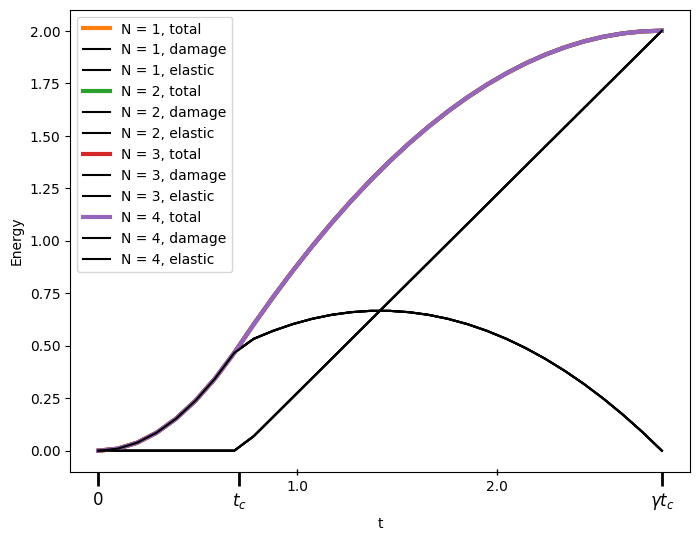

In [759]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
parameters = _matpar.copy()
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)

for _N in range(1, 5):
    parameters.update({N: _N})


    atls = SymbolicDiscreteDamage(parameters, _N)
    model = ModelAnalysis(atls)

    alpha = model.homogeneous_damage(parameters)
    
    _en = model.homogeneous_energy_fc_alpha()    \
                .replace(sp.Function('a'), model.model.a) \
                .replace(sp.Function('s'), model.model.s)      \
                .replace(sp.Function('w'), model.model.w)  \
                .subs(_matpar)          \
        .subs({sp.symbols('α_t'): alpha})
    
    subs_homog_α, _ = model._state_homog_substitutions()

    _energy_damage = model.model._damage().subs(subs_homog_α).subs(_matpar) \
                .replace(sp.Function('w'), model.model.w)  \
                .subs({sp.symbols('α_t'): alpha})

    _f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
    _f1 = sp.lambdify(t, _energy_damage, 'numpy')
    ax.plot(_loads, _f(_loads), label=f'N = {_N}, total', lw=3, c='C'+str(_N))
    ax.plot(_loads, _f1(_loads), c='k', label=f'N = {_N}, damage')
    ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label=f'N = {_N}, elastic')
    
ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

ax.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('t')
# plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

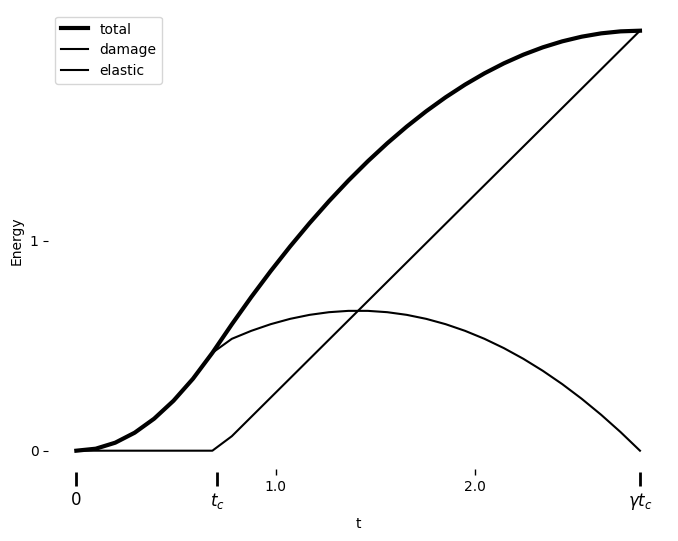

In [760]:
_en = model.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(sp.Function('a'), model.model.a) \
            .replace(sp.Function('s'), model.model.s)      \
            .replace(sp.Function('w'), model.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = model.model._damage().subs(subs_homog_α).subs(_matpar) \
            .replace(sp.Function('w'), model.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
figure, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(_loads, _f(_loads), c='k', label='total', lw=3)
ax.plot(_loads, _f1(_loads), c='k', label='damage')
ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

ax.legend()
plt.ylabel('Energy')
plt.xlabel('t')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

plt.yticks([0, 1])

for key, spine in ax.spines.items():
    spine.set_visible(False)

# plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

_en_homogeneous_t = _f



## Bifurcations

In [762]:
# we bifurcate m springs

m = 1

assert m < _matpar["N"]

In [777]:
model.energy_m_bifurcations()

0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*))) + w1*(m*α_t + α^**(N - m))

In [ ]:
# model._diff_energy_m_bifurcations(sp.symbols('m'))

In [780]:
bif_crit_m = sp.diff(
    model.energy_m_bifurcations().subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))                        \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)             \
        .simplify()

bif_crit_m

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [785]:
model.elastic_energy_xi_bifurcations()

0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*)))

In [786]:
model.energy_xi_bifurcations()


0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))) + w1*(xi*α_t + α^**(1 - xi))

In [788]:
bif_crit_xi = sp.diff(
    model.energy_xi_bifurcations()   \
    .subs({sp.symbols('α^*'): 0}) \
        , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .simplify()

bif_crit_xi

-0.5*E0*t**2*xi*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(xi*α_t*γ - α_t + 1)**2) + 1.0*w1*xi

1.47313912747197*t + 1.04166666666667
1.53787093999737*t + 1.08743897026187
1.60855303055436*t + 1.13741875580316
1.68604536633289*t + 1.19221411192214
1.77138201830986*t + 1.25255623721881
1.86581757017452*t + 1.31933225632741
1.97088920808537*t + 1.39362912400455
2.08850104147925*t + 1.47679324894515
2.22104053065005*t + 1.57051282051282
2.37154225038609*t + 1.67693360711841
2.54392307475336*t + 1.79882525697504
2.74332797134923*t + 1.93982581155978
2.97665225757224*t + 2.10481099656357
3.2533551434874*t + 2.30046948356808
3.58677352775785*t + 2.53623188405797
3.99633590289975*t + 2.82583621683968
4.51148857788292*t + 3.19010416666667
5.17910796384766*t + 3.66218236173393
6.07863724177909*t + 4.29824561403509
7.35631258559253*t + 5.20169851380043
9.31404093498409*t + 6.58602150537634
12.6916601751432*t + 8.97435897435897
19.9127771713453*t + 14.0804597701149
46.1976430375211*t + 32.6666666666666
144.367634492255*t - 102.083333333334
28.1692945350739*t - 19.9186991869919
15.6073118370

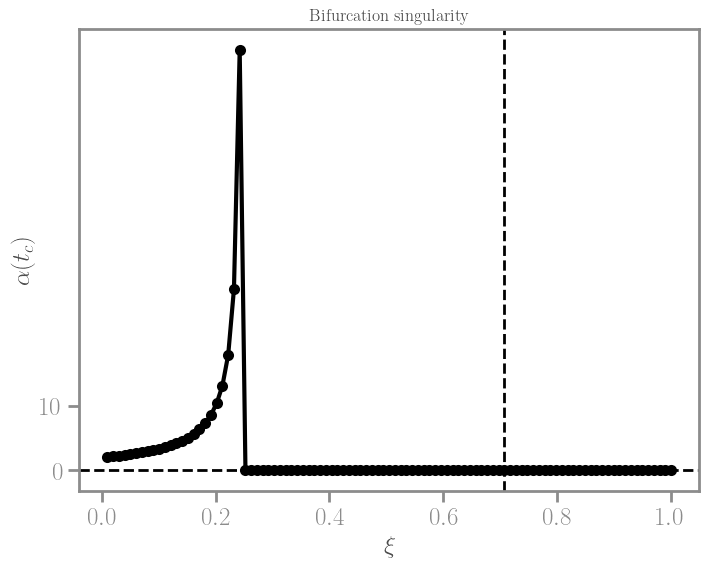

In [846]:
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_sequence = np.linspace(0.01, 1, 99)
parameters = _matpar.copy()

alpha_bif = []
tc = model.critical_load(parameters)[0]

# for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, _matpar)
    print(_sols[idx].subs(sp.symbols('xi'), _xi))
    alpha_bif.append({'alpha(tc)': _sols[idx].subs(sp.symbols('xi'), _xi).subs(t, tc), 'xi': _xi})

alpha_bif

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([a['xi'] for a in alpha_bif], [a['alpha(tc)'] for a in alpha_bif], marker='o', c='k', lw=3)
plt.title('Bifurcation singularity')
plt.xlabel('$\\xi$')
plt.ylabel('$\\alpha(t_c)$')
ax.set_yticks([0, 10])
# ax.set_xticks([0, 1, 1/3])
ax.axvline(tc, c='k', ls='--')
ax.axhline(0, c='k', ls='--')
# plt.semilogy()
# fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


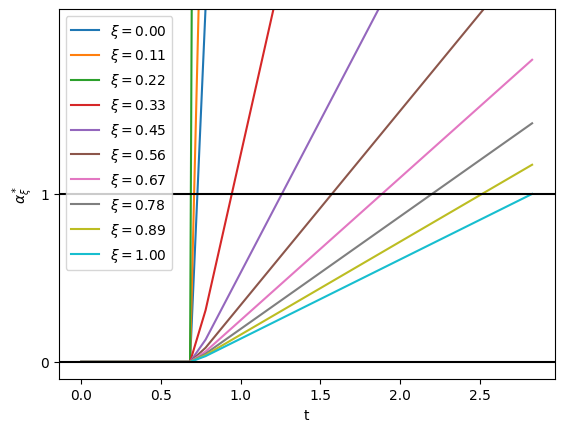

In [815]:
# sp.latex(
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
parameters = _matpar.copy()

tc = model.critical_load(parameters)[0]
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)


# fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# _sequence = np.linspace(0.001, 1, 10)

# # for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, _matpar)
    # print(idx)
#     idx = pos[0][0]
    # for sol in _sols[idx]:
#     # print(_sols[idx].subs(sp.symbols('xi'), _xi))
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
#     # _f = sp.lambdify(t, _sols[idx], 'numpy')
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    plt.plot(_loads, _f(_loads), label=f'$\\xi = {_xi:.2f}$')
plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')
# plt.xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
plt.yticks([0, 1])
plt.ylim(-.1, 2.1)

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

# fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


In [816]:
import seaborn as sns
palette = sns.color_palette("viridis", as_cmap=True)


In [819]:
t

t

In [820]:
tc

[0.707106781186548]

0

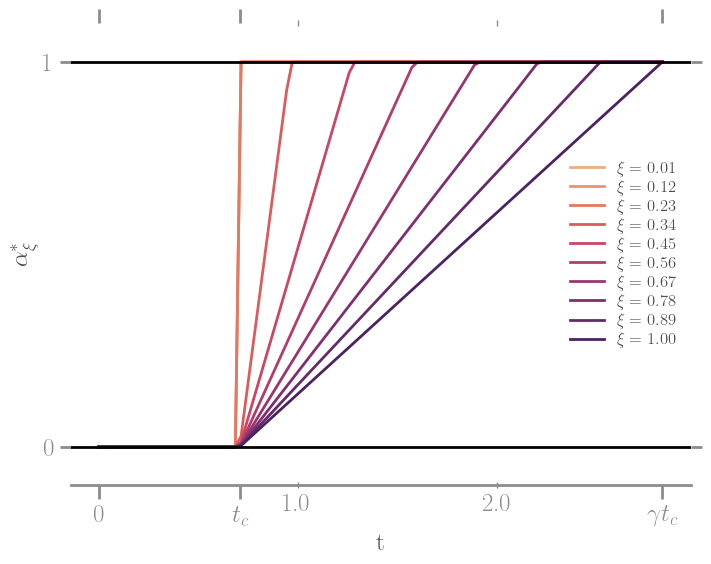

In [842]:
# sp.latex(

from visuals import *
parameters = _matpar.copy()

matplotlibdefaults(palette='light',useTex=True)

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(parameters['γ'] * tc), 100)
tc = model.critical_load(parameters)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.01, 1, 10)
palette = sns.color_palette("viridis", n_colors=10)
palette = sns.color_palette("Paired")
palette = sns.color_palette("rocket", as_cmap=True)
palette = sns.color_palette("flare", as_cmap=True)


for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, parameters)
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    ax.plot(_loads, np.minimum(_f(_loads), 1), label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))

plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k')

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

plt.yticks([0, 1])
plt.ylim(-.1, 1.1)
setspines0()
# fig.savefig(os.path.join(output_dir, 'bifurcation-by-xi.png'))


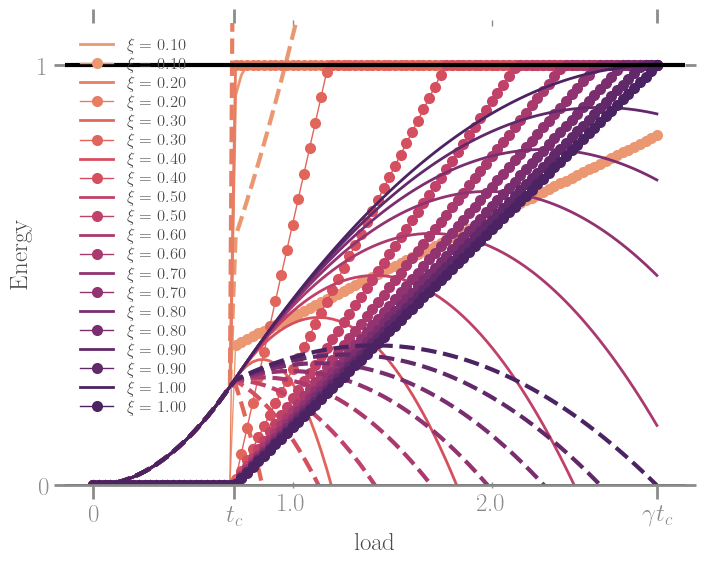

In [848]:
# Energy of bifurcated branches

parameters = _matpar.copy()

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(parameters['γ'] * tc), 100)
tc = model.critical_load(parameters)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.1, 1, 10)
# palette = sns.color_palette("viridis", n_colors=10)
# palette = sns.color_palette("Paired")
# palette = sns.color_palette("rocket", as_cmap=True)
# palette = sns.color_palette("flare", as_cmap=True)
    

for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, parameters)

    _total_xi_energy = model.energy_xi_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])


    _elastic_xi_energy = model.elastic_energy_xi_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])

    _total_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _total_xi_energy, 'numpy')
    _elastic_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _elastic_xi_energy, 'numpy')
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    alpha_t = _f(_loads)
    
    ax.plot(_loads, np.minimum(
            _total_xi_energy_alpha(_loads, alpha_t), 1), 
            label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))    
    ax.plot(_loads, _elastic_xi_energy_alpha(_loads, alpha_t), 
            # label=f'elastic $\\xi = {_xi:.2f}$', 
            lw =3, color = palette(_xi), ls='--')
    ax.plot(_loads, np.minimum(
        _total_xi_energy_alpha(_loads, alpha_t) - _elastic_xi_energy_alpha(_loads, alpha_t),
        1), 
            lw =1, color = palette(_xi), ls='-', marker='o', label=f'$\\xi = {_xi:.2f}$')
plt.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('load')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k')

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

ax.set_yticks([0, 1])
ax.axhline(0, c='k')
ax.set_ylim([0, 1.1])
ax.axhline(1, c='k', lw=3)
# model.xi_energy_m_bifurcations().subs(_normalise).subs({sp.symbols('α_*'): 0})
setspines0()
fig.savefig(os.path.join(output_dir, 'bifurcation-energy-xi.png'))
